# Convolution
Transform spatial image to frequency domain using wavelet transformation on Haar Coefficient

In [123]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

import pywt
import pywt.data
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

from sklearn.metrics import mean_squared_error
from math import sqrt

from ipynb.fs.full.task1 import convert_pgm_to_matrix, show_image_greyscale

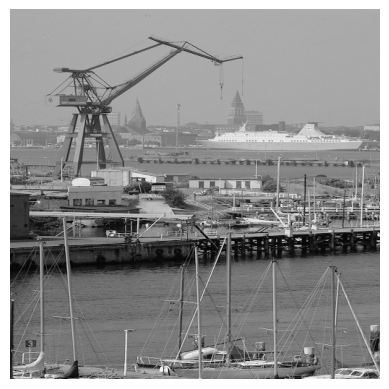

In [124]:
# Load image
im = convert_pgm_to_matrix("./Dataset/kiel.pgm")
show_image_greyscale(im)

In [125]:
# Image Utility function
def show_pic(pic):
    plt.imshow(pic, cmap=plt.cm.gray)

def show_images_4_grids(LL, LH, HL, HH, level):
    titles = ['Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
    fig = plt.figure(figsize=(8, 8))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(a, cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout()
    fig.text(0.37, 1, f"Wavelet transformation Level {level}")
    plt.show()

## Forward and Inverse Wavelet Transform

In [ ]:
def convolve_by_row(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row - 1, num_col))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r:r+2, c]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    
    return result

def convolve_by_column(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row, num_col - 1))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r, c:c+2]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    
    return result


def upsample_rows(matrix):
    """
    Upsample a 2D array along rows by inserting zeros between rows.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((2 * rows, cols))
    upsampled[::2, :] = matrix 

    return upsampled


def upsample_cols(matrix):
    """
    Upsample a 2D array along columns by inserting zeros between columns.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((rows, 2 * cols))
    upsampled[:, ::2] = matrix

    return upsampled

def add_right_padding(im):
    right_padding = np.zeros((im.shape[0], 1))
    return np.concatenate((im, right_padding), axis=1)

def add_bottom_padding(im):
    bottom_padding = np.zeros((1, im.shape[1]))
    return np.concatenate((im, bottom_padding))

def padding_preprocessing_col(im):
    num_columns = im.shape[1]
    if num_columns%2 != 0:
        im = add_right_padding(im)
    
    return im

def padding_preprocessing_row(im):
    num_rows = im.shape[0]
    if num_rows%2 != 0:
        im = add_bottom_padding(im)
    
    return im

def padding_preprocessing(im):
    num_rows = im.shape[0]
    num_cols = im.shape[1]
    if num_rows%2 != 0:
        im = add_bottom_padding(im)
    
    if num_cols%2 != 0:
        im = add_bottom_padding(im)
    
    return im

def downsample_cols(im):
    return im[:, ::2]

def downsample_rows(im):
    return im[::2, :]

low_pass_filter = np.array([1, 1]) / np.sqrt(2)
high_pass_filter = np.array([1, -1]) / np.sqrt(2)

In [ ]:
def forward_wavelet_transform(im, low_pass_filter, high_pass_filter):
    L = downsample_cols(convolve_by_column(padding_preprocessing_col(im), low_pass_filter))
    H = downsample_cols(convolve_by_column(padding_preprocessing_col(im), high_pass_filter))

    LL = downsample_rows(convolve_by_row(padding_preprocessing_row(L), low_pass_filter))
    LH = downsample_rows(convolve_by_row(padding_preprocessing_row(L), high_pass_filter))
    HL = downsample_rows(convolve_by_row(padding_preprocessing_row(H), low_pass_filter))
    HH = downsample_rows(convolve_by_row(padding_preprocessing_row(H), high_pass_filter))

    return LL, LH, HL, HH

def add_frequency(a, b):
    if a.shape == b.shape:
        return a + b
    
    diff_in_rows = a.shape[0] - b.shape[0]
    if diff_in_rows > 0:
        a = a[:-diff_in_rows, :]
    elif diff_in_rows < 0:
        b = b[:diff_in_rows, :]

    diff_in_cols = a.shape[1] - b.shape[1]
    if diff_in_cols > 0:
        a = a[:, :-diff_in_cols]
    elif diff_in_cols < 0:
        b = b[:, :diff_in_cols]
    
    return a+b

def inverse_wavelet_transform(LL, LH, HL, HH, low_pass_filter, high_pass_filter):
    reconstructed_L = add_frequency(convolve_by_row(upsample_rows(add_bottom_padding(LH)), high_pass_filter), convolve_by_row(upsample_rows(add_bottom_padding(LL)), low_pass_filter))
    reconstructed_H = convolve_by_row(upsample_rows(add_bottom_padding(HH)), high_pass_filter) + convolve_by_row(upsample_rows(add_bottom_padding(HL)), low_pass_filter)

    reconstructed_image = convolve_by_column(upsample_cols(add_right_padding(reconstructed_L)), low_pass_filter) + convolve_by_column(upsample_cols(add_right_padding(reconstructed_H)), high_pass_filter)

    # Crop to match the original size
    rows, cols = LL.shape[0] * 2, LL.shape[1] * 2
    return reconstructed_image[:rows, :cols]

In [ ]:
def forward_wavelet_transform_with_level(image, level, low_pass_filter, high_pass_filter):
    result = []
    for l in range(1, level+1):
        LL, LH, HL, HH = forward_wavelet_transform(image, low_pass_filter, high_pass_filter)
        image = LL
        show_images_4_grids(LL, LH, HL, HH, l)
        
        result.append(
            {
                "LL": LL, 
                "LH": LH, 
                "HL": HL, 
                "HH": HH
            }
        )
    
    return result

def inverse_wavelet_transform_many_levels(res, low_pass_filter, high_pass_filter):
    level = len(res)
    reconstructed_im = None
    
    for l in range(level - 1, -1, -1):
        LL, LH, HL, HH = res[l]["LL"], res[l]["LH"], res[l]["HL"], res[l]["HH"]
        if not reconstructed_im is None:
            LL = reconstructed_im
        
        print("LL shape---", LL.shape) 
        reconstructed_im = inverse_wavelet_transform(LL, LH, HL, HH, low_pass_filter, high_pass_filter)
        print("Reconstruct shape---", reconstructed_im.shape)

    return reconstructed_im
        

# Test go and back

## Odd

In [292]:
LL, LH, HL, HH = forward_wavelet_transform(brain, low_pass_filter, high_pass_filter)
ri = inverse_wavelet_transform(LL, LH, HL, HH, low_pass_filter, high_pass_filter)

reconstructed L shape:  (913, 350)
reconstructed H shape:  (913, 350)


In [293]:
brain.shape

(911, 699)

In [294]:
ri.shape

(912, 700)

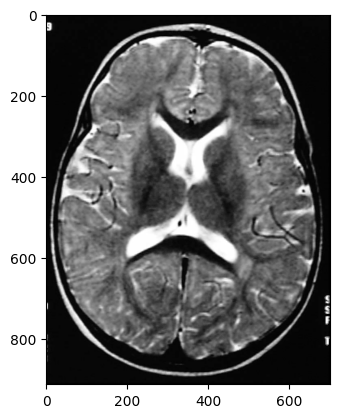

In [295]:
show_pic(ri)

## Even

In [289]:
LL, LH, HL, HH = forward_wavelet_transform(im, low_pass_filter, high_pass_filter)
ri = inverse_wavelet_transform(LL, LH, HL, HH, low_pass_filter, high_pass_filter)

reconstructed L shape:  (513, 256)
reconstructed H shape:  (513, 256)


In [275]:
im.shape

(512, 512)

In [290]:
ri.shape

(512, 512)

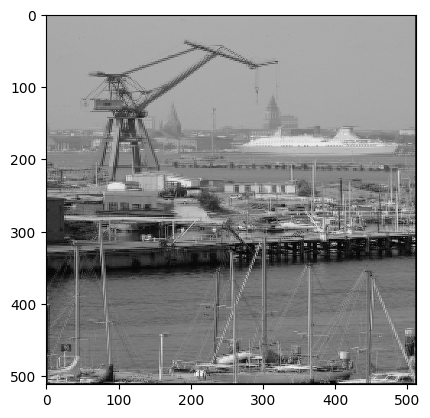

In [291]:
show_pic(ri)

LL shape--- (64, 64)
reconstructed L shape:  (129, 64)
reconstructed H shape:  (129, 64)
Reconstruct shape--- (128, 128)
LL shape--- (128, 128)
reconstructed L shape:  (257, 128)
reconstructed H shape:  (257, 128)
Reconstruct shape--- (256, 256)
LL shape--- (256, 256)
reconstructed L shape:  (513, 256)
reconstructed H shape:  (513, 256)
Reconstruct shape--- (512, 512)


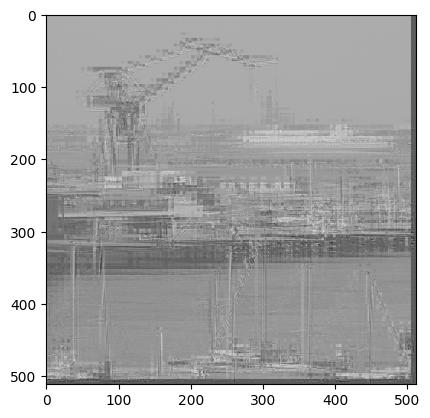

In [352]:
res = forward_wavelet_transform_with_level(im, 3, low_pass_filter, high_pass_filter)
reconstructed_image = inverse_wavelet_transform_many_levels(res, low_pass_filter, high_pass_filter)
show_pic(reconstructed_image)

In [300]:
reconstructed_image.shape

(512, 512)

LL shape--- (114, 88)
reconstructed L shape:  (229, 88)
reconstructed H shape:  (229, 88)
Reconstruct shape--- (228, 176)
LL shape--- (228, 176)
Before---
(457, 175)
(457, 176)
row diff =  0
col diff= -1
After---
(457, 175)
(457, 175)
reconstructed L shape:  (457, 175)
reconstructed H shape:  (457, 175)
Reconstruct shape--- (456, 351)
LL shape--- (456, 351)
Before---
(913, 350)
(913, 351)
row diff =  0
col diff= -1
After---
(913, 350)
(913, 350)
reconstructed L shape:  (913, 350)
reconstructed H shape:  (913, 350)
Reconstruct shape--- (912, 701)


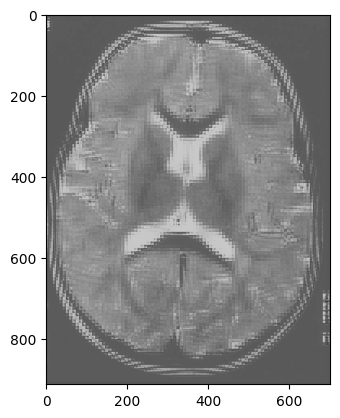

In [351]:
res = forward_wavelet_transform_with_level(brain, 3, low_pass_filter, high_pass_filter)
reconstructed_image = inverse_wavelet_transform_many_levels(res, low_pass_filter, high_pass_filter)
show_pic(reconstructed_image)

In [319]:
res[2]["LH"].shape

(114, 88)

In [ ]:
d

In [320]:
176/2

88.0

In [347]:
a = np.arange(12).reshape(3,4)
b= np.arange(10).reshape(2,5)

In [336]:
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [348]:
b

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [349]:
b[:, :-1]

array([[0, 1, 2, 3],
       [5, 6, 7, 8]])

In [350]:
def add_frequency(a, b):
    if a.shape == b.shape:
        return a + b
    
    print("Before---")
    print(a.shape)
    print(b.shape)
    diff_in_rows = a.shape[0] - b.shape[0]
    print("row diff = ", diff_in_rows)
    if diff_in_rows > 0:
        a = a[:-diff_in_rows, :]
    elif diff_in_rows < 0:
        b = b[:diff_in_rows, :]

    diff_in_cols = a.shape[1] - b.shape[1]
    print("col diff=", diff_in_cols)
    if diff_in_cols > 0:
        a = a[:, :-diff_in_cols]
    elif diff_in_cols < 0:
        b = b[:, :diff_in_cols]
    
    print("After---")
    print(a.shape)
    print(b.shape)
    return a+b

In [340]:
add_frequency(a, b)

row diff =  1
col diff= -1
[[0 1 2 3]
 [4 5 6 7]]
[[0 1 2 3]
 [5 6 7 8]]


array([[ 0,  2,  4,  6],
       [ 9, 11, 13, 15]])

In [337]:
a[:-1, :]

array([[0, 1, 2, 3],
       [4, 5, 6, 7]])

In [ ]:
b[:, :diff_in_rows]